from google.colab import drive
drive.mount('/content/gdrive')[Текст ссылки](https://)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [9]:
from os import listdir

data_directory = "../data/bayes-lab/messages/"
listdir(data_directory)

['part3',
 'part4',
 'part5',
 'part2',
 'part10',
 'part9',
 'part7',
 'part1',
 'part6',
 'part8']

In [10]:
class Message:
    def __init__(self, data, is_legit):
        self.data = data
        self.is_legit = is_legit

    def __str__(self):
        return "legit: " + str(self.is_legit) + ", data: " + str(self.data)

    def __repr__(self):
        return "legit: " + str(self.is_legit) + ", data: " + str(self.data)

In [12]:
from os.path import join
from pathlib import Path

data = []
for subdir in sorted(listdir(data_directory), key=lambda x: int(x[4:])):
    cur_dir = join(data_directory, subdir)
    dir_data = []
    for file_name in listdir(cur_dir):
        is_legit = 'legit' in file_name
        cur_file = Path(join(cur_dir, file_name))
        lines = cur_file.read_text().split('\n')
        lines[0] = lines[0][9:]
        file_data = list(lines[0].split()) + list(lines[2].split())
        dir_data.append(Message(file_data, is_legit))
    data.append(dir_data)

In [13]:
import math

def naive_bayes_classifier(lambdas, alpha, train_input, test_input, class_amount=2):
    Q_dim = 2
    eps = 1e-5
    all_words = set()
    lmbd = lambdas
    n_train = len(train_input)
    train_classes = []
    classes = [i for i in range(class_amount)]
    train_data = [set() for _ in range(n_train)]
    class_amount_with_word = {}
    amount_of_class = [0 for _ in classes]

    # read train data
    for i in range(n_train):
        # row = list(train_input[i].split())
        row = train_input[i]
        cur_class = int(row.pop(0)) - 1
        train_classes.append(cur_class)
        amount_of_class[cur_class] += 1
        # row.pop(0)
        for word in row:
            train_data[i].add(word)
            all_words.add(word)

    # read test data
    n_test = len(test_input)
    test_data = [set() for _ in range(n_test)]
    for i in range(n_test):
        # row = list(test_input[i].split())
        row = test_input[i]
        # row.pop(0)
        for word in row:
            test_data[i].add(word)

    # count up amount of classes the word refers to
    for i in range(n_train):
        words_set = train_data[i]
        current_class = train_classes[i]
        for word in words_set:
            if word in class_amount_with_word:
                class_amount_with_word[word][current_class] += 1
            else:
                class_amount_with_word[word] = [0 for _ in classes]
                class_amount_with_word[word][current_class] += 1

    # count up P(W_i|C_y)
    prob_w_c = [{} for _ in classes]
    for word in class_amount_with_word.keys():
        for c in classes:
            count = class_amount_with_word[word][c]
            prob_w_c[c][word] = float(count + alpha) / float(amount_of_class[c] + alpha * Q_dim)

    # count up P(C)
    prob_c = []
    for c in classes:
        prob_c.append(amount_of_class[c] / n_train)
        # print(prob_c[c])

    # print answer for every query X
    res = []
    for i in range(n_test):
        class_score = [0.0 for _ in classes]
        for c in classes:
            if amount_of_class[c] != 0:
                # replace the probabilities product by the sum of the logarithms to avoid too small numbers
                # which would result from the probabilities product
                cur_score = math.log(lmbd[c]) + math.log(prob_c[c])
                for word in all_words:
                    if word in test_data[i]:
                        cur_score += math.log(prob_w_c[c][word])
                    else:
                        cur_score += math.log(1 - prob_w_c[c][word])
                class_score[c] = cur_score
        max_log = max(class_score)
        sum_score = 0.0
        for c in range(len(class_score)):
            if abs(class_score[c]) > eps:
                class_score[c] = math.exp(class_score[c] - max_log)
                sum_score += class_score[c]
            else:
                class_score[c] = 0
        ans = []
        for c in classes:
            # print(class_score[c] / sum_score, end=' ')
            ans.append(class_score[c] / sum_score)
        res.append(ans)
    return res

In [14]:
def construct_train_data(input: [Message]):
  train_data = []
  for msg in input:
    if msg.is_legit:
      c = 1
    else:
      c = 2
    c = str(c)
    train_data.append([c] + msg.data)
  return train_data

In [15]:
def message_to_n_gram(msg: Message, n: int):
    n_grammed_data = []
    for i in range(0, len(msg.data), n):
        cur_word = ''
        if i + n - 1 >= len(msg.data):
            for j in range(0, len(msg.data) - i):
                cur_word += msg.data[i + j]
        else:
            for j in range(n):
                cur_word += msg.data[i + j]
        if cur_word != '':
            n_grammed_data.append(cur_word)
    return Message(n_grammed_data, msg.is_legit)


In [16]:
def construct_n_gram(input: [Message], n: int):
  n_grammed_data = []
  for msg in input:
    n_grammed_msg = message_to_n_gram(msg, n)
    n_grammed_data.append(n_grammed_msg)
  return n_grammed_data

In [17]:
def get_k_fold_train_data(data: [[str]], k):
    res = []
    for i in range(len(data)):
        if i != k:
            res = res + data[i]
    return res

In [18]:
def count_accuracy(expected, predicted):
    right_amount = 0
    assert (len(expected) == len(predicted))
    for i in range(len(expected)):
        if expected[i] == predicted[i]:
            right_amount += 1
    return right_amount / len(expected)

In [19]:
def count_accuracy_only_legit(expected, predicted):
    right_amount = 0
    amount = 0
    assert (len(expected) == len(predicted))
    for i in range(len(expected)):
        if expected[i] == 1:
            amount += 1
            if expected[i] == predicted[i]:
                right_amount += 1
    return right_amount / amount

In [20]:
def check_legit(expected, predicted):
    # print(len(expected), len(predicted))
    for i in range(len(expected)):
        if expected[i] == 1 and predicted[i] == 2:
            return False
    return True

In [21]:
def execute(alpha, train_data: [Message], test_data: [Message], n, ll, ls):
    train = construct_train_data(construct_n_gram(train_data, n))
    test = [msg.data for msg in construct_n_gram(test_data, n)]
    lambdas = [ll, ls]
    res = naive_bayes_classifier(lambdas, alpha, train, test)
    class_list_predicted = []
    class_list_expected = []
    for row in res:
        if row[0] >= row[1]:
            class_list_predicted.append(1)
        else:
            class_list_predicted.append(2)
    for msg in test_data:
        if msg.is_legit:
            class_list_expected.append(1)
        else:
            class_list_expected.append(2)
    return class_list_expected, class_list_predicted

In [205]:
n_set = [1, 2, 3]
alpha_set = [1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1.0, 10.0]
l_spam = 1
l_legit = 1
for n in n_set:
    for alpha in alpha_set:
        acc = []
        for k in range(10):
            expected, predicted = execute(alpha, get_k_fold_train_data(data, k), data[k], n, l_legit, l_spam)
            acc.append(count_accuracy(expected, predicted))
        print("n =", n, ", alpha =", alpha, ", accuracy =", sum(acc) / len(acc))


n = 1 , alpha = 1e-12 , accuracy = 0.9715596330275229
n = 1 , alpha = 1e-10 , accuracy = 0.9715596330275229
n = 1 , alpha = 1e-08 , accuracy = 0.9706422018348624
n = 1 , alpha = 1e-06 , accuracy = 0.9678899082568808
n = 1 , alpha = 0.0001 , accuracy = 0.9660550458715598
n = 1 , alpha = 0.01 , accuracy = 0.9587155963302753
n = 1 , alpha = 1.0 , accuracy = 0.9155963302752295
n = 1 , alpha = 10.0 , accuracy = 0.7027522935779816
n = 2 , alpha = 1e-12 , accuracy = 0.9724770642201837
n = 2 , alpha = 1e-10 , accuracy = 0.9697247706422019
n = 2 , alpha = 1e-08 , accuracy = 0.9688073394495413
n = 2 , alpha = 1e-06 , accuracy = 0.9605504587155964
n = 2 , alpha = 0.0001 , accuracy = 0.9504587155963303
n = 2 , alpha = 0.01 , accuracy = 0.9192660550458717
n = 2 , alpha = 1.0 , accuracy = 0.7596330275229357
n = 2 , alpha = 10.0 , accuracy = 0.5844036697247706
n = 3 , alpha = 1e-12 , accuracy = 0.9587155963302753
n = 3 , alpha = 1e-10 , accuracy = 0.9467889908256879
n = 3 , alpha = 1e-08 , accuracy =

In [22]:
def check_legit_k_fold(l_legit):
    n = 1
    alpha = 1e-10
    l_spam = 1
    for k in range(10):
        expected, predicted = execute(alpha, get_k_fold_train_data(data, k), data[k], n, l_legit, l_spam)
        if not check_legit(expected, predicted):
            return False
    return True

# l_legit_set = [1e44, 1e45] # alpha = 1e-6
l_legit_set = [1e80, 1e81] # alpha = 1e-10
for l_legit in l_legit_set:
    print(check_legit_k_fold(l_legit))

False
True


In [16]:
l_spam = 1
l_legit = 1
n = 2
alpha = 1e-12
all_expected = []
all_predicted = []
for k in range(10):
    expected, predicted = execute(alpha, get_k_fold_train_data(data, k), data[k], n, l_legit, l_spam)
    all_expected = all_expected + expected
    all_predicted = all_predicted + predicted


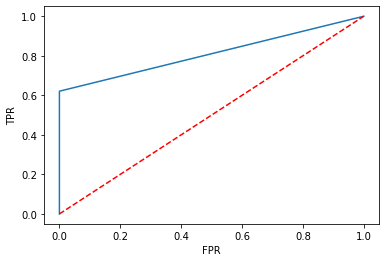

0.8104166666666667


In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

l_spam = 1
l_legit = 1e81
n = 1
alpha = 1e-10
all_expected = []
all_predicted = []
for k in range(10):
    expected, predicted = execute(alpha, get_k_fold_train_data(data, k), data[k], n, l_legit, l_spam)
    all_expected = all_expected + expected
    all_predicted = all_predicted + predicted

expected = list(map(lambda x: int(x) - 1, all_expected))
predicted = list(map(lambda x: int(x) - 1, all_predicted))
assert(len(expected) == len(predicted))
fpr, tpr, threshold = roc_curve(expected, predicted)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
print(auc(fpr, tpr))

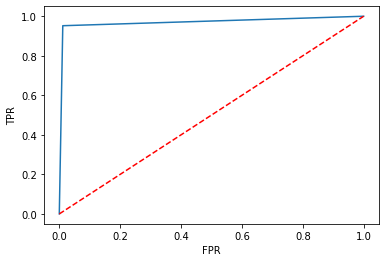

0.970303961748634


In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

expected = list(map(lambda x: int(x) - 1, all_expected))
predicted = list(map(lambda x: int(x) - 1, all_predicted))
assert(len(expected) == len(predicted))
fpr, tpr, threshold = roc_curve(expected, predicted)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
print(auc(fpr, tpr))

In [23]:
l_legit_set = []
for l in [10 ** i for i in range(0, 81, 2)]:
    l_legit_set.append(l)
ys = []

for l_legit in l_legit_set:
    acc = []
    for k in range(10):
        expected, predicted = execute(alpha, get_k_fold_train_data(data, k), data[k], n, l_legit, l_spam)
        acc.append(count_accuracy(expected, predicted))
    cur_acc = sum(acc) / len(acc)
    ys.append(cur_acc)
    print(cur_acc)


0.9724770642201837
0.9715596330275231
0.9706422018348626
0.9697247706422019
0.9688073394495413
0.9678899082568808
0.9678899082568808
0.965137614678899
0.965137614678899
0.9642201834862385
0.9633027522935782
0.9614678899082569
0.9596330275229359
0.9577981651376147
0.9568807339449542
0.9559633027522937
0.9559633027522937
0.9513761467889909
0.9504587155963303
0.9467889908256881
0.9477064220183486
0.9449541284403671
0.9449541284403671
0.9449541284403671
0.9449541284403671
0.9449541284403671
0.9449541284403671
0.9422018348623855
0.9403669724770645
0.9366972477064219
0.9348623853211008
0.9330275229357797
0.9311926605504587
0.9293577981651376
0.9275229357798166
0.9256880733944955
0.9266055045871561
0.922935779816514
0.9192660550458716
0.9174311926605505
0.9165137614678898


In [ ]:
plt.xlabel('l_legit')
plt.ylabel('accuracy')
plt.plot(l_legit_set, ys)
plt.show()

In [ ]:
xs = list(map(lambda x: math.log10(x), l_legit_set))
plt.plot(xs, ys)
plt.xlabel('l_legit (degree of 10)')
plt.ylabel('accuracy')
plt.show()

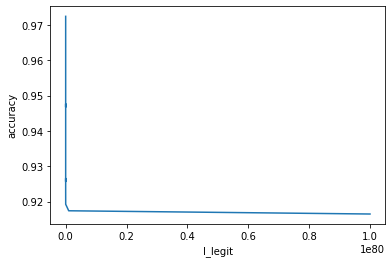

[1, 100, 10000, 1000000, 100000000, 10000000000, 1000000000000, 100000000000000, 10000000000000000, 1000000000000000000, 100000000000000000000, 10000000000000000000000, 1000000000000000000000000, 100000000000000000000000000, 10000000000000000000000000000, 1000000000000000000000000000000, 100000000000000000000000000000000, 10000000000000000000000000000000000, 1000000000000000000000000000000000000, 100000000000000000000000000000000000000, 10000000000000000000000000000000000000000, 1000000000000000000000000000000000000000000, 100000000000000000000000000000000000000000000, 10000000000000000000000000000000000000000000000, 1000000000000000000000000000000000000000000000000, 100000000000000000000000000000000000000000000000000, 10000000000000000000000000000000000000000000000000000, 1000000000000000000000000000000000000000000000000000000, 100000000000000000000000000000000000000000000000000000000, 10000000000000000000000000000000000000000000000000000000000, 100000000000000000000000000000000000000

In [25]:
xs = list(map(lambda x: math.log10(x), l_legit_set))
plt.plot(xs, ys)
plt.xlabel('l_legit (degree of 10)')
plt.ylabel('accuracy')
plt.show()

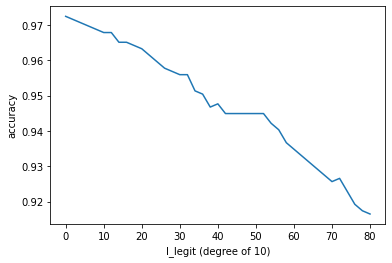

In [27]:
xs = list(map(lambda x: math.log10(x), l_legit_set))
plt.plot(xs, ys)
plt.xlabel('l_legit (degree of 10)')
plt.ylabel('accuracy')
plt.show()